In [349]:
pip install pandas numpy opencv-python pillow matplotlib tensorflow keras visualkeras pennylane

  Using cached keras-3.9.1-py3-none-any.whl.metadata (6.1 kB)
Using cached keras-3.9.1-py3-none-any.whl (1.3 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
Note: you may need to restart the kernel to use updated packages.


In [350]:
import os
import random

import pandas as pd
import numpy as np

import cv2
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from timeit import default_timer as timer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPool2D ,Dropout

import visualkeras

In [351]:
all_0 = "C-NMC_Leukemia/training_data/fold_0/all"
all_1 = "C-NMC_Leukemia/training_data/fold_1/all"
all_2 = "C-NMC_Leukemia/training_data/fold_2/all"

hem_0 = "C-NMC_Leukemia/training_data/fold_0/hem"
hem_1 = "C-NMC_Leukemia/training_data/fold_1/hem"
hem_2 = "C-NMC_Leukemia/training_data/fold_2/hem"
path_val ='C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data'
val_labels = pd.read_csv('C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

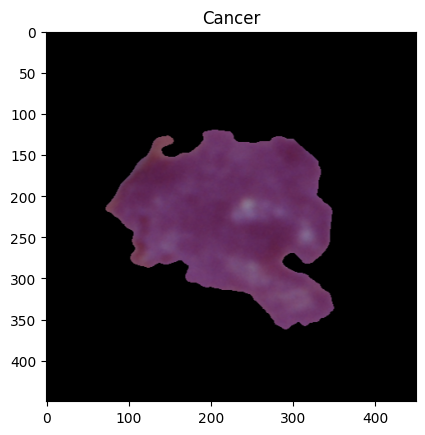

In [352]:
a_image_fnames = os.listdir(all_0)
cancer_img = cv2.imread(os.path.join(all_0,a_image_fnames[5]))
plt.imshow(cancer_img)
plt.title('Cancer')
plt.show()

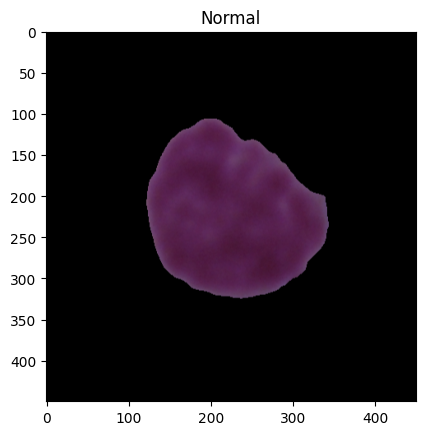

In [353]:
h_image_fnames = os.listdir(hem_0)
h_img = cv2.imread(os.path.join(hem_0,h_image_fnames[5]))
plt.imshow(h_img)
plt.title('Normal')
plt.show()

In [354]:
##Get the shape of the image 
h_img.shape

(450, 450, 3)

In [355]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder) 
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)
    
    return image_paths

In [356]:
#image absolute paths for cancer cells and normal cells
cancer_lst = []

for i in [all_0,all_1,all_2]:
    paths = get_path_image(i)
    cancer_lst.extend(paths)
print('No. of cancer images:', len(cancer_lst))

normal_lst = []
for i in [hem_0,hem_1,hem_2]:
    paths = get_path_image(i)
    normal_lst.extend(paths)
print('No. of normal images:', len(normal_lst))

No. of cancer images: 7272
No. of normal images: 3389


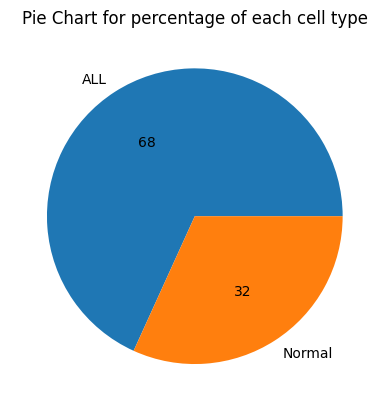

In [357]:
cancer_dict = {"x_col":cancer_lst, "y_col":[np.nan for x in range(len(cancer_lst))]}
cancer_dict["y_col"] = "ALL"

normal_dict = {"x_col":normal_lst, "y_col":[np.nan for x in range(len(normal_lst))]}
normal_dict["y_col"] = "HEM"


cancer_df = pd.DataFrame(cancer_dict)
normal_df = pd.DataFrame(normal_dict)

#train_df = cancer_df.append(normal_df, ignore_index=True)

plt.pie([len(cancer_lst),len(normal_lst)],labels=["ALL","Normal"],autopct='%.f')
plt.title('Pie Chart for percentage of each cell type')
plt.show()

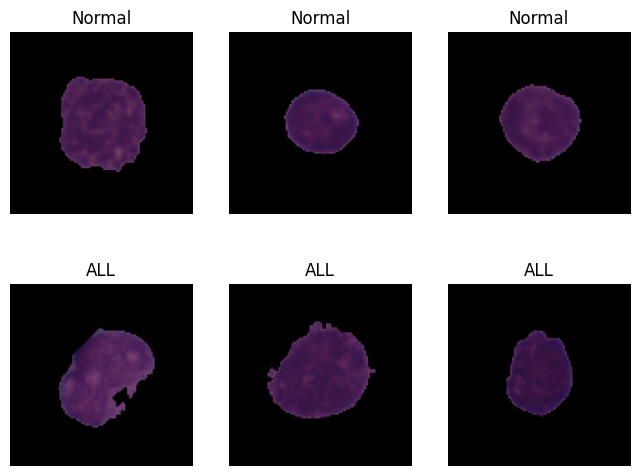

In [358]:
select_normal = np.random.choice(normal_lst, 3, replace = False)
select_all = np.random.choice(cancer_lst, 3, replace = False)


fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = select_normal[i]
        label = 'Normal'
    else:
        fp = select_all[i-3]
        label = 'ALL'
    ax = fig.add_subplot(2, 3, i+1) 
    fn = image.load_img(fp, target_size = (100,100),
                        color_mode='rgb')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

In [359]:
train_df = pd.concat([cancer_df, normal_df], ignore_index=True)

In [360]:
validation_list = get_path_image(path_val)
#0 - нормальные клетки, 1 - раковые

validation_dict = {"x_col":validation_list ,"y_col":val_labels["labels"]}
validation_df = pd.DataFrame(validation_dict)
validation_df["y_col"].replace(to_replace = [1,0], value = ["ALL","HEM"], inplace = True)

C:\Users\mello_onii\AppData\Local\Temp\ipykernel_22384\3387290801.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  validation_df["y_col"].replace(to_replace = [1,0], value = ["ALL","HEM"], inplace = True)


In [361]:
# Code Resizig For teating data
test_data = 'C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data'
test_list = get_path_image(test_data)

test_dict = {"x_col":test_list}

test_df = pd.DataFrame(test_dict)

In [362]:
size = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
                  train_df,
                  x_col = "x_col",
                  y_col = "y_col",
                  target_size = (size, size),
                 
                  batch_size = 32,
                  color_mode = "rgb",
                  shuffle = True,
                  class_mode = "binary"
)

val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_dataframe(
                  validation_df,
                  x_col = "x_col",
                  y_col = "y_col",
                  target_size = (size, size),                  
                  batch_size = 32,
                  color_mode = "rgb",
                  shuffle = True,
                  class_mode = "binary")


test_datagen = ImageDataGenerator(rescale=1./255 )
test_generator = test_datagen.flow_from_dataframe(
                  test_df,
                  x_col = "x_col",
                  target_size = (size, size),
                  color_mode = "rgb",
                  class_mode = None,
                  shuffle = False
)

Found 10661 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.
Found 2586 validated image filenames.


In [363]:
import numpy as np
from collections import Counter

# Получаем распределение классов
class_counts = Counter(train_generator.classes)
print(class_counts)

Counter({0: 7272, 1: 3389})


In [364]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.7330170517051705, 1: 1.5728828562997934}


In [252]:
model = tf.keras.models.Sequential([
    layers.ZeroPadding2D(padding=(2, 2), input_shape=(size, size, 3)),
    layers.Conv2D(30, (5, 5), strides=1, padding="valid", activation='relu'),
    layers.Dropout(0.4),
    
    layers.ZeroPadding2D(padding=(2, 2)),
    layers.Conv2D(30, (5, 5), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    layers.Dropout(0.6),
    
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

In [336]:
model.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d_26               │ (None, 228, 228, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_204 (Conv2D)             │ (None, 224, 224, 30)   │         2,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 224, 224, 30)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_27               │ (None, 228, 228, 30)   │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_205 (Conv2D)             │ (None, 224, 224, 30)   │        22,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 112, 112, 30)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 112, 112, 30)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 376320)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 2)              │       752,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_qml_layer_4              │ (None, 2)              │             0 │
│ (CustomQMLLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 777,455 (2.97 MB)

 Trainable params: 777,455 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

In [337]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [338]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start = timer()
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, 
                    class_weight={0: 0.73, 1: 1.57})

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/20


c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['sequential_38/conv2d_204/kernel', 'sequential_38/conv2d_204/bias', 'sequential_38/conv2d_205/kernel', 'sequential_38/conv2d_205/bias', 'sequential_38/dense_79/kernel', 'sequential_38/dense_79/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


UnknownError: Graph execution error:

Detected at node sequential_38_1/custom_qml_layer_4_1/PyFunc defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\mello_onii\anaconda3\Lib\asyncio\windows_events.py", line 322, in run_forever

  File "c:\Users\mello_onii\anaconda3\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\mello_onii\anaconda3\Lib\asyncio\base_events.py", line 1986, in _run_once

  File "c:\Users\mello_onii\anaconda3\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\mello_onii\AppData\Local\Temp\ipykernel_22384\4184172655.py", line 5, in <module>

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 371, in fit

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 219, in function

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 132, in multi_step_on_iterator

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 113, in one_step_on_data

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 57, in train_step

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 909, in __call__

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 52, in __call__

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\models\sequential.py", line 221, in call

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 183, in call

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 643, in call

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 909, in __call__

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 52, in __call__

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\mello_onii\AppData\Local\Temp\ipykernel_22384\2389628490.py", line 27, in call

QuantumFunctionError: A quantum function must return either a single measurement, or a nonempty sequence of measurements.
Traceback (most recent call last):

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\pennylane\workflow\qnode.py", line 905, in __call__
    return self._impl_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\pennylane\workflow\qnode.py", line 868, in _impl_call
    tape = self.construct(args, kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\pennylane\logging\decorators.py", line 61, in wrapper_entry
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\pennylane\workflow\qnode.py", line 861, in construct
    _validate_qfunc_output(self._qfunc_output, tape.measurements)

  File "c:\Users\mello_onii\anaconda3\Lib\site-packages\pennylane\workflow\qnode.py", line 164, in _validate_qfunc_output
    raise qml.QuantumFunctionError(

pennylane.QuantumFunctionError: A quantum function must return either a single measurement, or a nonempty sequence of measurements.


	 [[{{node sequential_38_1/custom_qml_layer_4_1/PyFunc}}]] [Op:__inference_multi_step_on_iterator_916766]

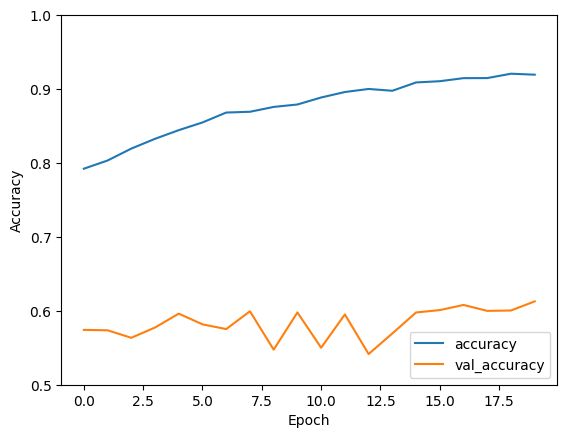

In [257]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
model.save('model.h5')

c:\Users\mello_onii\anaconda3\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


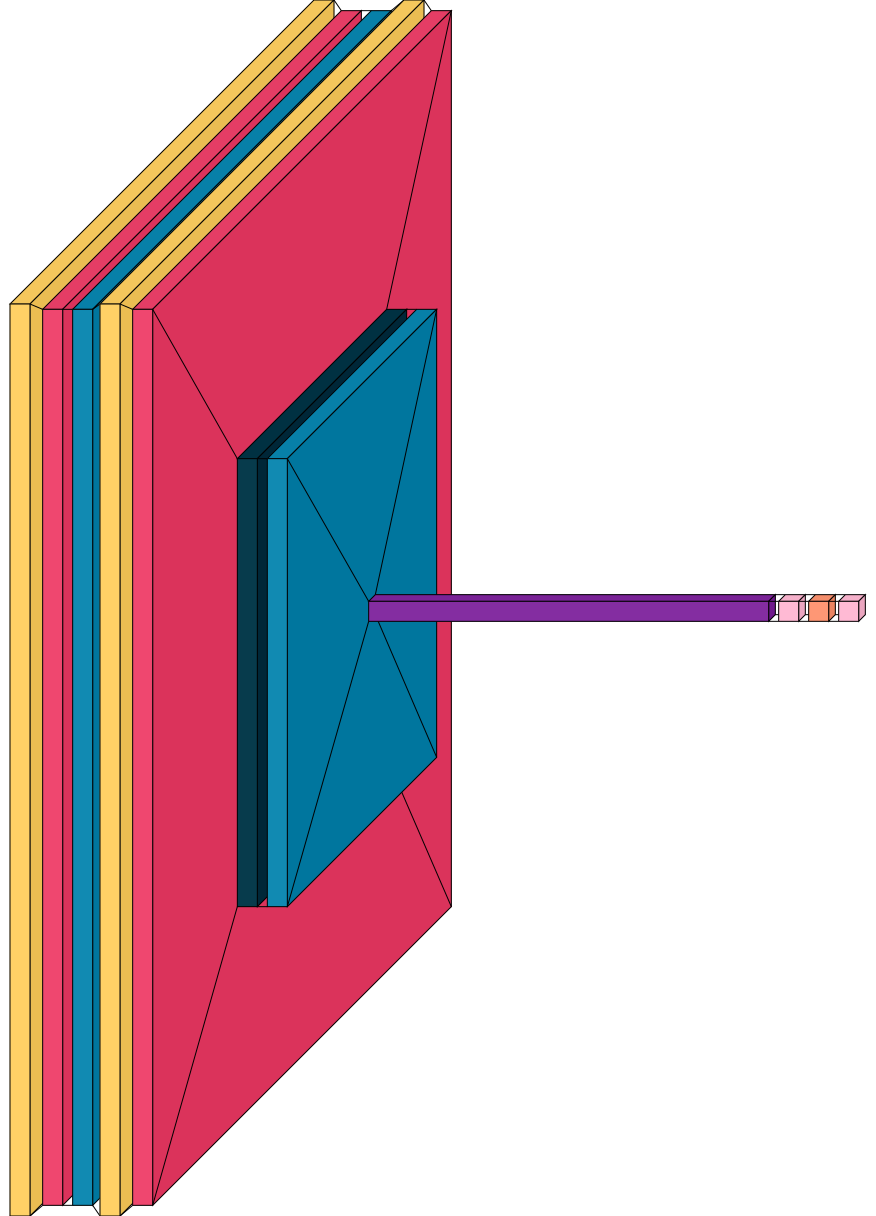

In [368]:
visualkeras.layered_view(model)

In [261]:
def testing(image_path):
    test_image = image.load_img(image_path,target_size=(size,size))
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image,axis=0)
    result = model.predict(test_image)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
[[0.]]


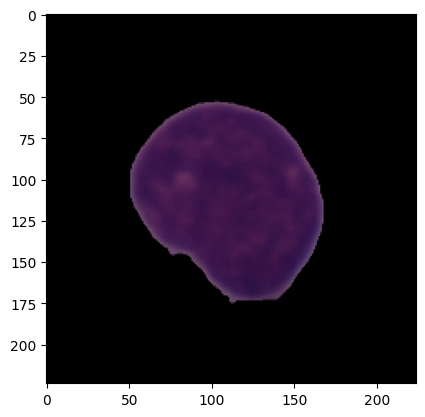

In [262]:
image_path = 'C-NMC_Leukemia/training_data/fold_0/all/UID_1_6_1_all.bmp'
testing(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.]]


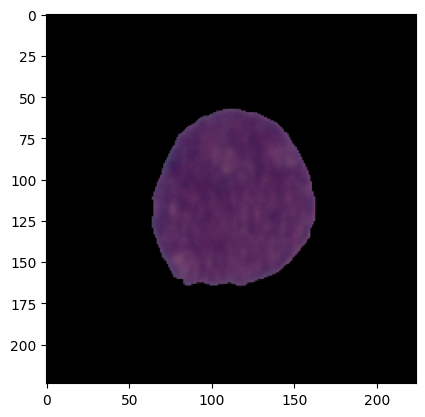

In [263]:
image_path = 'C-NMC_Leukemia/training_data/fold_2/all/UID_78_9_4_all.bmp'
testing(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[1.]]


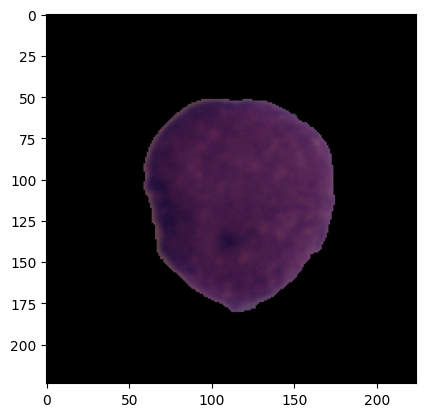

In [264]:
image_path = 'C-NMC_Leukemia/training_data/fold_0/hem/UID_H6_1_2_hem.bmp'
testing(image_path)